<a href="https://colab.research.google.com/github/SnoopiACK/DientesMask/blob/master/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP para identificar numero de diente dada su posición y su clase.

In [1]:
import torch, torchvision
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import json
import os

repo_url = 'https://github.com/SnoopiACK/DientesMask'
!git clone {repo_url}
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
%cd {repo_dir_path}
!git pull

Cloning into 'DientesMask'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 669 (delta 27), reused 65 (delta 7), pack-reused 557
Receiving objects: 100% (669/669), 298.91 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (215/215), done.
Checking out files: 100% (322/322), done.
/content/DientesMask
Already up to date.


In [0]:
#dada una carpeta de jsons con dientes enumerados, hacer un pd dataframe
def jsons_to_df(jsons_path):
  jsons_list = [f for f in os.listdir(jsons_path) if ".json" in f]
  teeth_list = []
  for json_filename in jsons_list:
    json_file = json.load( open(os.path.join(jsons_path, json_filename), encoding = 'cp1252' ) )
    height = json_file['imageHeight']
    width = json_file['imageWidth']
    for shape in json_file['shapes']:
      x_min, x_max = shape['points'][0][0], shape['points'][1][0]
      y_min, y_max = shape['points'][0][1], shape['points'][1][1]
      x_avg = ( x_min + x_max ) / 2
      y_avg = ( y_min + y_max ) / 2
      relative_x_avg = x_avg / width
      relative_y_avg = y_avg / height
      relative_width = abs(x_max - x_min)/width #en caso que por algun motivo min y max esten  intercambiados
      relative_height = abs(y_max - y_min)/height
      if relative_width > relative_height:
        relative_width, relative_height = relative_height, relative_width
      label = shape['label']
      if label == "0":
        continue
      teeth_list.append( [label, relative_x_avg, relative_y_avg, relative_width, relative_height ] )
  df = pd.DataFrame(teeth_list, columns=['Label','X', 'Y', 'Width', 'Height'])
  return df

#dado el numero de diente, saber si es incisivo, canino, premolar, molar
def get_tooth_type(tooth_number):
  if len(tooth_number) == 2:
    c = tooth_number[1]
  else:
    c = tooth_number 
  if (c == '1') or (c == '2'):
    tooth_type = 'Incisivo'
  elif (c == '3'):
    tooth_type = 'Canino'
  elif (c == '4') or (c == '5'):
    tooth_type = 'Premolar'
  else:
    tooth_type = 'Molar'  
  return tooth_type
  
#encoding de tipo de diente
def tooth_type_encoder(tooth_type):
  encoder_dict = {
      "Incisivo":0,
      "Canino":1,
      "Premolar":2,
      "Molar":3
  }
  return encoder_dict[tooth_type]

#encoding de numero de diente
def tooth_number_encoder(tooth_number):
  tooth_number = int(tooth_number)
  d = tooth_number // 10
  u = tooth_number % 10
  return (u-1) + (d-1) * 8

#hacer un one hot vector dado el numero de categorias, y la categoria en cuestion
def one_hot_encoder(cat_number, total_cats):
  one_hot = np.zeros(total_cats);
  one_hot[cat_number] = 1;
  return one_hot

#dataset para el mlp
class Teeth_number_dataset(torch.utils.data.Dataset):
    def __init__(self, jsons_path):
      self.dataframe = jsons_to_df(jsons_path)

    def __len__(self):
      return len(self.dataframe)

    def __getitem__(self, idx):
      X = self.dataframe.iloc[idx]['X']
      Y = self.dataframe.iloc[idx]['Y']
      width = self.dataframe.iloc[idx]['Width']
      height = self.dataframe.iloc[idx]['Height']
      tooth_number = self.dataframe.iloc[idx]['Label']
      tooth_type_one_hot = one_hot_encoder( tooth_type_encoder(get_tooth_type(tooth_number)), 4)
      tooth_number_one_hot = one_hot_encoder( tooth_number_encoder(tooth_number), 32 )
      input_vector = torch.cat((torch.tensor([X,Y], dtype=float),torch.tensor((width,height), dtype = float),torch.tensor(tooth_type_one_hot)),0)
      return (input_vector, tooth_number_one_hot)
      

## El MLP tendrá 8 entradas (x,y,ancho,alto + un feature vector con las 4 clases posibles) y 32 salidas (los 32 tipos de diente)
### Dudas:
- hidden layers?
- hidden size?

In [0]:
num_epochs = 100
batch_size = 32
learning_rate = 1e-4

input_size = 8 
output_size = 32
hidden_size = 60


class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.hidden_1 = nn.Linear(hidden_size, hidden_size)
    self.hidden_2 = nn.Linear(hidden_size, hidden_size)
    self.output_layer = nn.Linear(hidden_size, output_size) 
        
  def forward(self, x):
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_1(x))
    x = F.relu(self.hidden_2(x))
    x = self.output_layer(x)
    return x

train_dataset = Teeth_number_dataset("data/jsons_dientes_enumerados/train")
test_dataset = Teeth_number_dataset("data/jsons_dientes_enumerados/test")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [31]:
model = MLP()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model.cuda()
model.double()

train_loss_avg = []
test_loss_avg = []

for epoch in range(num_epochs):
  model.train()
  train_loss_avg.append(0)
  num_batches = 0
  for i, (input_vector,output_vector) in enumerate(train_dataloader):
    input_vector = input_vector.cuda()
    output_vector = output_vector.cuda()
    predictions = model(input_vector)
    loss = criterion(predictions, torch.max(output_vector, 1)[1])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss_avg[-1] += loss.item()
    num_batches += 1

  train_loss_avg[-1] /= num_batches
  print('Epoch [%d / %d] average train loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

  model.eval()
  with torch.no_grad():
    test_loss_avg.append(0)
    num_batches = 0    
    for (input_vector,output_vector) in test_dataloader:
      input_vector = input_vector.cuda()
      output_vector = output_vector.cuda()
      predictions = model(input_vector)
      loss = criterion(predictions, torch.max(output_vector, 1)[1])
      test_loss_avg[-1] += loss.item()
      num_batches += 1

    test_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average test loss: %f' % (epoch+1, num_epochs, test_loss_avg[-1]))



Epoch [1 / 100] average train loss: 3.463848
Epoch [1 / 100] average test loss: 3.459189
Epoch [2 / 100] average train loss: 3.454440
Epoch [2 / 100] average test loss: 3.448873
Epoch [3 / 100] average train loss: 3.441472
Epoch [3 / 100] average test loss: 3.432752
Epoch [4 / 100] average train loss: 3.420004
Epoch [4 / 100] average test loss: 3.404077
Epoch [5 / 100] average train loss: 3.381346
Epoch [5 / 100] average test loss: 3.352571
Epoch [6 / 100] average train loss: 3.312950
Epoch [6 / 100] average test loss: 3.263165
Epoch [7 / 100] average train loss: 3.198555
Epoch [7 / 100] average test loss: 3.121608
Epoch [8 / 100] average train loss: 3.034642
Epoch [8 / 100] average test loss: 2.938133
Epoch [9 / 100] average train loss: 2.846140
Epoch [9 / 100] average test loss: 2.749453
Epoch [10 / 100] average train loss: 2.668430
Epoch [10 / 100] average test loss: 2.582712
Epoch [11 / 100] average train loss: 2.517509
Epoch [11 / 100] average test loss: 2.448581
Epoch [12 / 100] 

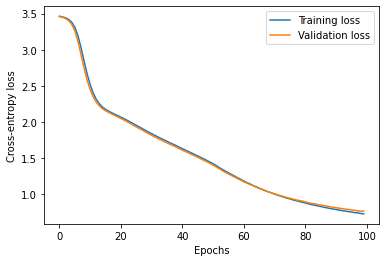

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_loss_avg)
plt.plot(test_loss_avg)
plt.legend(('Training loss', 'Validation loss'))
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()


In [33]:
test_loss_avg = 0
num_incorrect = 0
num_instances = 0
cm = np.zeros((32,32))
model.eval()
total_predicted_labels = torch.tensor((), dtype = int).cuda()
total_ground_truth_labels = torch.tensor((), dtype = int).cuda()
with torch.no_grad():
  for (input_vector,output_vector) in test_dataloader:
    input_vector = input_vector.cuda()
    output_vector = output_vector.cuda()
    predictions = model(input_vector)
    predicted_labels = torch.max(predictions, 1)[1]
    ground_truth_labels = torch.max(output_vector, 1)[1]
    total_predicted_labels = torch.cat((total_predicted_labels, predicted_labels),0)
    total_ground_truth_labels = torch.cat((total_ground_truth_labels, ground_truth_labels),0)
    num_incorrect += (predicted_labels != ground_truth_labels).sum().item()
    loss = criterion(predictions, torch.max(output_vector, 1)[1])
    test_loss_avg += loss.item()
    num_batches += 1
    num_instances += input_vector.size(0)



test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))
print('accuracy: %f%%' % ( (num_instances-num_incorrect)/num_instances ) )




average loss: 0.383037
accuracy: 0.732639%


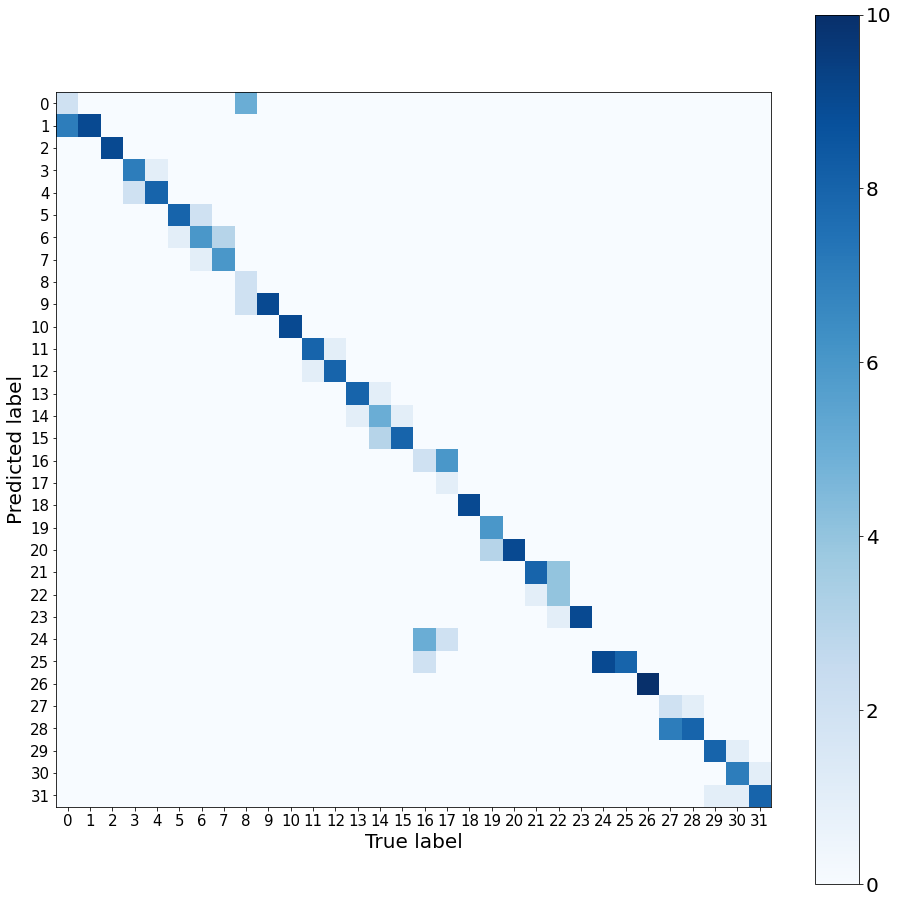

In [34]:
def plot_matrix(ground_truth_labels, predicted_labels):
    cm = confusion_matrix(ground_truth_labels, predicted_labels)
    plt.tick_params(labelsize=15)
    ax = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    cb = plt.colorbar()
    cb.ax.tick_params(axis='both', labelsize=20)
    plt.ylabel("Predicted label", fontsize=20)
    plt.xlabel("True label", fontsize=20)
    plt.xticks(range(32))
    plt.yticks(range(32))
    
    return ax

plt.figure(figsize=(16, 16))
plot_matrix(total_predicted_labels.cpu(), total_ground_truth_labels.cpu())